### Pregunta 1

#### Continuación **agregando parte 1, en una clase**

Se agregó las funciones de la parte 1 en una clase llamada Ngrama

In [22]:
corpus = ['all models are wrong','a model is wrong','some models are useful']
vocab = ['<s>','</s>','a','all','are','model','models','some','useful','wrong']

#### a) Calcular todas las probabilidades de los bigramas sin suavisado

In [49]:
import re

class Ngrama:
    def __init__(self, corpus , vocab ):
        # Inicializamos el vocabulario
        self.vocab = vocab
        # Tokenizamos el corpus de acuerdo a la naturaleza del corpus
        if isinstance(corpus,list):
            self.corpus_tokenized = self.preprocesar_list_corpus(corpus)
        elif isinstance(corpus,str):
            corpus_tokenized = self.tokenized_text(corpus)
            self.corpus_tokenized = self.preprocesar_list_corpus(corpus_tokenized)
        else:
            print('El corpus debe ser un texto o una lista de oraciones')

        # Definimos los unigramas, bigramas del corpus y sus frecuencias
        self.unigrams =  self.get_freq_ngrams(self.corpus_tokenized,1)
        self.bigrams  =  self.get_freq_ngrams(self.corpus_tokenized,2)

        # Calculamos el total de bigramas
        self.total_bigrams = self.get_freq_t_bigrams(self.bigrams)

    def get_freq_t_bigrams(self,bigrams:dict)->dict:
        t_bigram_freq = {}
        for word1 in vocab:
            for word2 in vocab:
                bigram = (word1,word2)
                t_bigram_freq[bigram] = bigrams.get((word1,word2),0)
        return t_bigram_freq   

    def get_freq_ngrams(self,corpus_tokenized:list, n_type: int)->dict:
        ngrams_freq = {}
        n = len(corpus_tokenized)
        for i in range(n-n_type+1):
            ngram = tuple(corpus_tokenized[i:i+n_type])
            if ngram not in ngrams_freq:
                ngrams_freq[ngram]=1
            else:
                ngrams_freq[ngram]+=1
        return ngrams_freq

    def preprocesar_list_corpus(self,corpus:list):
        new_sentence = ['<s>']
        for sentence in corpus :
            # Preprocesamos una oracion en token de palabras
            sentence_tokenized = self.tokenized_sentence(sentence)            
            # Agregamos el tag de final de oracion
            new_sentence += (sentence_tokenized + ['</s>']) 
        return new_sentence
        
    def tokenized_sentence(self,sentence:str)->list:
        pattern = re.compile(r'\b\w+\b')
        words = pattern.findall(sentence)
        
        # Verificamos si cada palabra esta en el vocabulario
        tokenized_words = [word.lower() if word in self.vocab else '<unk>' for word in words]
        
        return tokenized_words

    def tokenized_text(self,text:str)->list:
        return re.split(r'(?<=[.!?])\s+',text)

    def get_prob_bigram(self,bigrams:dict,unigrams:dict):
        prob_bigrams = {}
        for bigram,freq in bigrams.items():
            prob_bigrams[bigram] = (freq)/(unigrams[(bigram[0],)])
        return prob_bigrams

    def get_prob_add_k_bigram(self,bigrams:dict,unigrams:dict,k:float):
        # Tamaño del vocabulario
        V = len(vocab)        
        # Cálculo de las probabilidades suavizadas
        add_k_probabilities = {}
        for (w1,w2), freq in bigrams.items():
            N = unigrams.get((w1,),0)
            # Aplicando la ecuación P_Add-k(w_i) = (c_i + k) / (N + kV)
            add_k_probabilities[(w1,w2)] = (freq + k) / (N + k * V)
            #print(f'({w1},{w2}) = ({freq} + {k}) / ({N} + {k} * {V}) = {(freq + k) / (N + k * V)} ')        
        return add_k_probabilities
        

    def get_prob_stupid_backoff_bigram(self, bigrams: dict, unigrams: dict, lambda_factor: float):
        """
        Calcula las probabilidades usando Stupid Backoff.
        Si el bigrama no se ha visto, retrocede al unigram y multiplica por lambda.
        Nota: Para bigramas el backoff y stupid backoff sale lo mismo.
        """
        stupid_backoff_probabilities = {}
        V = len(self.vocab)  # Tamaño del vocabulario

        for bigram, freq in self.total_bigrams.items():
            w1, w2 = bigram
            if bigram in bigrams and bigrams[bigram] > 0:
                # Si el bigrama existe, calcular la probabilidad normal
                stupid_backoff_probabilities[bigram] = bigrams[bigram] / unigrams[(w1,)]
            else:
                # Retrocedemos al unigram y multiplicamos por lambda
                stupid_backoff_probabilities[bigram] = lambda_factor * (unigrams.get((w2,), 0) / sum(unigrams.values()))

        return stupid_backoff_probabilities
    ########################################################### PARTE 2 ##########################################    
    def calculate_N_r(self, ngram_counts: dict):
        """
        Calcula N_r, donde r es la frecuencia y N_r es el número de n-gramas
        que ocurren exactamente r veces.
        """
        N_r = {}
        for count in ngram_counts.values():
            if count not in N_r:
                N_r[count] = 1
            else:
                N_r[count] += 1

        # Definir N_0 = 1 como el número de elementos no observados
        N_r[0] = 1
        return N_r

    def good_turing_smoothing(self, ngram_counts: dict, N_r: dict) -> dict:
        
        adjusted_counts = {}

        # Para cada n-grama en los conteos
        for ngram, count in ngram_counts.items():
            r = count
            if r + 1 in N_r and r in N_r:
                # Aplicar la formula Good-Turing: c* = (r+1) * (N_{r+1} / N_r)
                adjusted_count = (r + 1) * (N_r[r + 1] / N_r[r])
            else:
                # Para valores grandes de r o cuando no hay N_{r+1}, dejamos el valor como esta
                adjusted_count = r

            adjusted_counts[ngram] = adjusted_count

        return adjusted_counts

    def calculate_good_turing_probabilities(self, adjusted_counts: dict):
        
        total_adjusted_count = len(adjusted_counts)
        probabilities = {ngram: count / total_adjusted_count for ngram, count in adjusted_counts.items()}
        return probabilities
        
    def apply_good_turing(self):
        
        # Calculamos N_r a partir de los conteos de bigramas
        N_r = self.calculate_N_r(self.bigrams)

        # Ajustamos los conteos con Good-Turing
        adjusted_bigrams = self.good_turing_smoothing(self.bigrams, N_r)

        # Calculamos las probabilidades ajustadas
        good_turing_probabilities = self.calculate_good_turing_probabilities(adjusted_bigrams)
        
        return good_turing_probabilities
    
        


In [50]:
ml = Ngrama(corpus,vocab)

In [51]:
ml.unigrams

{('<s>',): 1,
 ('all',): 1,
 ('models',): 2,
 ('are',): 2,
 ('wrong',): 2,
 ('</s>',): 3,
 ('a',): 1,
 ('model',): 1,
 ('<unk>',): 1,
 ('some',): 1,
 ('useful',): 1}

In [52]:
ml.bigrams

{('<s>', 'all'): 1,
 ('all', 'models'): 1,
 ('models', 'are'): 2,
 ('are', 'wrong'): 1,
 ('wrong', '</s>'): 2,
 ('</s>', 'a'): 1,
 ('a', 'model'): 1,
 ('model', '<unk>'): 1,
 ('<unk>', 'wrong'): 1,
 ('</s>', 'some'): 1,
 ('some', 'models'): 1,
 ('are', 'useful'): 1,
 ('useful', '</s>'): 1}

In [53]:
total_freq = ml.get_freq_t_bigrams(ml.bigrams)

## Probabilidades sin Suavizado

prob_bigramas = ml.get_prob_bigram(total_freq,ml.unigrams)

In [54]:
prob_bigramas = ml.get_prob_bigram(total_freq,ml.unigrams)
prob_ord = sorted( prob_bigramas.items() , key = lambda x: x[1]  , reverse = True)[:10]
print('Top 10 - Probabilidades sin suavizado')
for (bigram,prob) in prob_ord:
    print(f'{bigram}: {prob}')

Top 10 - Probabilidades sin suavizado
('<s>', 'all'): 1.0
('a', 'model'): 1.0
('all', 'models'): 1.0
('models', 'are'): 1.0
('some', 'models'): 1.0
('useful', '</s>'): 1.0
('wrong', '</s>'): 1.0
('are', 'useful'): 0.5
('are', 'wrong'): 0.5
('</s>', 'a'): 0.3333333333333333


## Probabilidades con Suavizado add-one

In [55]:
add_k_probabilities =ml.get_prob_add_k_bigram(total_freq,ml.unigrams,k=1)

prob_ord = sorted( add_k_probabilities.items() , key = lambda x: x[1]  , reverse = True)[:10]
print('Top 10 - Probabilidades con suavizado add-one')
for (bigram,prob) in prob_ord:
    print(f'{bigram}: {prob}')

Top 10 - Probabilidades con suavizado add-one
('models', 'are'): 0.25
('wrong', '</s>'): 0.25
('<s>', 'all'): 0.18181818181818182
('a', 'model'): 0.18181818181818182
('all', 'models'): 0.18181818181818182
('some', 'models'): 0.18181818181818182
('useful', '</s>'): 0.18181818181818182
('are', 'useful'): 0.16666666666666666
('are', 'wrong'): 0.16666666666666666
('</s>', 'a'): 0.15384615384615385


In [56]:
# Veamos un ejemplo de los posibles bigramas del vocabulario y sus probabilidades
# Para el unigram : 'models' 
suma = 0
for bigram,p in add_k_probabilities.items():
    if bigram[0] == 'models':
        print(f'{bigram} : {p}')
        suma+=p
print(f'suma probabilidades: {suma}')

('models', '<s>') : 0.08333333333333333
('models', '</s>') : 0.08333333333333333
('models', 'a') : 0.08333333333333333
('models', 'all') : 0.08333333333333333
('models', 'are') : 0.25
('models', 'model') : 0.08333333333333333
('models', 'models') : 0.08333333333333333
('models', 'some') : 0.08333333333333333
('models', 'useful') : 0.08333333333333333
('models', 'wrong') : 0.08333333333333333
suma probabilidades: 1.0


### Bigrama no visto : **( a , models )**

In [57]:
# Para el Bigrama a models
bigrama = ('a','models')
for bigram,p in add_k_probabilities.items():
    if bigram == bigrama:
        print(f'{bigram} : {p}')
    

('a', 'models') : 0.09090909090909091


## Probabilidades sin Suavizado add-k = 0.05

In [58]:
add_k_probabilities_1 =ml.get_prob_add_k_bigram(total_freq,ml.unigrams,k=0.05)

prob_ord = sorted( add_k_probabilities_1.items() , key = lambda x: x[1]  , reverse = True)[:10]
print('Top 10 - Probabilidades con suavizado add-k = 0.05')
for (bigram,prob) in prob_ord:
    print(f'{bigram}: {prob}')

Top 10 - Probabilidades con suavizado add-k = 0.05
('models', 'are'): 0.82
('wrong', '</s>'): 0.82
('<s>', 'all'): 0.7000000000000001
('a', 'model'): 0.7000000000000001
('all', 'models'): 0.7000000000000001
('some', 'models'): 0.7000000000000001
('useful', '</s>'): 0.7000000000000001
('are', 'useful'): 0.42000000000000004
('are', 'wrong'): 0.42000000000000004
('</s>', 'a'): 0.3


Vemos que las probabilidades se han reducido, porque se ha suavizado para los bigramas que no aparecen en el corpus

In [59]:
# Veamos un ejemplo de los posibles bigramas del vocabulario y sus probabilidades
# Para el unigram : 'models' 
suma = 0
for bigram,p in add_k_probabilities_1.items():
    if bigram[0] == 'models':
        print(f'{bigram} : {p}')
        suma+=p
print(f'suma probabilidades: {suma}')

('models', '<s>') : 0.02
('models', '</s>') : 0.02
('models', 'a') : 0.02
('models', 'all') : 0.02
('models', 'are') : 0.82
('models', 'model') : 0.02
('models', 'models') : 0.02
('models', 'some') : 0.02
('models', 'useful') : 0.02
('models', 'wrong') : 0.02
suma probabilidades: 1.0


### Bigrama no visto : **( a , models )**

In [60]:
# Para el Bigrama a models
bigrama = ('a','models')
for bigram,p in add_k_probabilities_1.items():
    if bigram == bigrama:
        print(f'{bigram} : {p}')

('a', 'models') : 0.03333333333333333


## Probabilidades sin Suavizado add-k = 0.15

In [61]:
add_k_probabilities_2 =ml.get_prob_add_k_bigram(total_freq,ml.unigrams,k=0.15)

prob_ord = sorted( add_k_probabilities_2.items() , key = lambda x: x[1]  , reverse = True)[:10]
print('Top 10 - Probabilidades con suavizado add-k = 0.15')
for (bigram,prob) in prob_ord:
    print(f'{bigram}: {prob}')

Top 10 - Probabilidades con suavizado add-k = 0.15
('models', 'are'): 0.6142857142857142
('wrong', '</s>'): 0.6142857142857142
('<s>', 'all'): 0.45999999999999996
('a', 'model'): 0.45999999999999996
('all', 'models'): 0.45999999999999996
('some', 'models'): 0.45999999999999996
('useful', '</s>'): 0.45999999999999996
('are', 'useful'): 0.32857142857142857
('are', 'wrong'): 0.32857142857142857
('</s>', 'a'): 0.25555555555555554


In [62]:
# Veamos un ejemplo de los posibles bigramas del vocabulario y sus probabilidades
# Para el unigram : 'models' 
suma = 0
for bigram,p in add_k_probabilities_2.items():
    if bigram[0] == 'models':
        print(f'{bigram} : {p}')
        suma+=p
print(f'suma probabilidades: {suma}')

('models', '<s>') : 0.04285714285714286
('models', '</s>') : 0.04285714285714286
('models', 'a') : 0.04285714285714286
('models', 'all') : 0.04285714285714286
('models', 'are') : 0.6142857142857142
('models', 'model') : 0.04285714285714286
('models', 'models') : 0.04285714285714286
('models', 'some') : 0.04285714285714286
('models', 'useful') : 0.04285714285714286
('models', 'wrong') : 0.04285714285714286
suma probabilidades: 0.9999999999999997


### Bigrama no visto : **( a , models )**

In [63]:
# Para el Bigrama a models
bigrama = ('a','models')
for bigram,p in add_k_probabilities_2.items():
    if bigram == bigrama:
        print(f'{bigram} : {p}')

('a', 'models') : 0.06


## Backoff y stupid-backoff

In [64]:
# Probamos la funcion Stupid Backoff con lambda = 0.4
lambda_factor = 0.4
stupid_backoff_probabilities = ml.get_prob_stupid_backoff_bigram(total_freq, ml.unigrams, lambda_factor)

# Verificamos si las probabilidades suman 1 para el unigram 'models'
sum_prob_stupid_backoff = 0
for bigram, prob in stupid_backoff_probabilities.items():
    if bigram[0] == 'models':
        print(f"{bigram}: {prob}")
        sum_prob_stupid_backoff += prob

print(f"Suma de probabilidades (Stupid Backoff) para 'models': {sum_prob_stupid_backoff}")

('models', '<s>'): 0.025
('models', '</s>'): 0.07500000000000001
('models', 'a'): 0.025
('models', 'all'): 0.025
('models', 'are'): 1.0
('models', 'model'): 0.025
('models', 'models'): 0.05
('models', 'some'): 0.025
('models', 'useful'): 0.025
('models', 'wrong'): 0.05
Suma de probabilidades (Stupid Backoff) para 'models': 1.3249999999999997


# PARTE 2

### (e) - Cálculo de r , Nr , N0



In [65]:
# Unigramas de la parte 1
ml.unigrams

{('<s>',): 1,
 ('all',): 1,
 ('models',): 2,
 ('are',): 2,
 ('wrong',): 2,
 ('</s>',): 3,
 ('a',): 1,
 ('model',): 1,
 ('<unk>',): 1,
 ('some',): 1,
 ('useful',): 1}

In [66]:
# Aplicar el cálculo de N_r para los unigramas
Nr_unigrams = ml.calculate_N_r(ml.unigrams)

# Mostrar los resultados
print("Nr para los unigramas:", Nr_unigrams)
print("Valor de N_0:", Nr_unigrams.get(0, 0))


Nr para los unigramas: {1: 7, 2: 3, 3: 1, 0: 1}
Valor de N_0: 1


### (f) Calculo de cr para r < 3 

In [67]:
# Aplicamos suavizado Good-Turing a los unigramas
adjusted_unigrams = ml.good_turing_smoothing(ml.unigrams, Nr_unigrams)
adjusted_unigrams

{('<s>',): 0.8571428571428571,
 ('all',): 0.8571428571428571,
 ('models',): 1.0,
 ('are',): 1.0,
 ('wrong',): 1.0,
 ('</s>',): 3,
 ('a',): 0.8571428571428571,
 ('model',): 0.8571428571428571,
 ('<unk>',): 0.8571428571428571,
 ('some',): 0.8571428571428571,
 ('useful',): 0.8571428571428571}

In [68]:
# Calculamos probabilidades ajustadas
good_turing_probabilities = ml.calculate_good_turing_probabilities(adjusted_unigrams)
good_turing_probabilities

{('<s>',): 0.07792207792207792,
 ('all',): 0.07792207792207792,
 ('models',): 0.09090909090909091,
 ('are',): 0.09090909090909091,
 ('wrong',): 0.09090909090909091,
 ('</s>',): 0.2727272727272727,
 ('a',): 0.07792207792207792,
 ('model',): 0.07792207792207792,
 ('<unk>',): 0.07792207792207792,
 ('some',): 0.07792207792207792,
 ('useful',): 0.07792207792207792}

In [69]:
# Mostrar los resultados para los unigramas con r < 3
print("Probabilidades ajustadas Good-Turing (r < 3):")
for unigram, prob in good_turing_probabilities.items():
    count = ml.unigrams[unigram]
    if count < 3:
        print(f"{unigram}: {prob}")

Probabilidades ajustadas Good-Turing (r < 3):
('<s>',): 0.07792207792207792
('all',): 0.07792207792207792
('models',): 0.09090909090909091
('are',): 0.09090909090909091
('wrong',): 0.09090909090909091
('a',): 0.07792207792207792
('model',): 0.07792207792207792
('<unk>',): 0.07792207792207792
('some',): 0.07792207792207792
('useful',): 0.07792207792207792


### (g) Cálculo de la probabilidad mediante MLE para r máximo

In [70]:
# MLE: si N_{r+1} = 0, calculamos la probabilidad P(w | #w = r)
r_max = max(Nr_unigrams.keys())
print(f'r_max = {r_max}')

# Calculamos probabilidad con MLE
def calculate_MLE(ngram_counts):
    total_count = sum(ngram_counts.values())
    probabilities = {ngram: count / total_count for ngram, count in ngram_counts.items()}
    return probabilities

# Probabilidades con MLE para el valor máximo de r
mle_probabilities = calculate_MLE(ml.unigrams)

# Mostramos las probabilidades MLE
print(f"Probabilidades MLE para r máximo ({r_max}):")
for unigram, prob in mle_probabilities.items():
    count = ml.unigrams[unigram]
    if count == r_max:
        print(f"{unigram}: {prob}")


r_max = 3
Probabilidades MLE para r máximo (3):
('</s>',): 0.1875


### (h) - Normalización de las probabilidades para que sumen 1

In [71]:
# Mostramos que la suma no es 1
good_turing_probabilities

{('<s>',): 0.07792207792207792,
 ('all',): 0.07792207792207792,
 ('models',): 0.09090909090909091,
 ('are',): 0.09090909090909091,
 ('wrong',): 0.09090909090909091,
 ('</s>',): 0.2727272727272727,
 ('a',): 0.07792207792207792,
 ('model',): 0.07792207792207792,
 ('<unk>',): 0.07792207792207792,
 ('some',): 0.07792207792207792,
 ('useful',): 0.07792207792207792}

In [72]:
s = 0
for unigram,p in good_turing_probabilities.items():
    s+=p
print('Suma de probabilidades: ',s)

Suma de probabilidades:  1.090909090909091


In [74]:
# Normalizar probabilidades para que sumen 1
def normalize_probabilities(probabilities):
    total_prob = sum(probabilities.values())
    normalized_probs = {ngram: prob / total_prob for ngram, prob in probabilities.items()}
    return normalized_probs

# Normalizamos las probabilidades ajustadas
normalized_good_turing_probs = normalize_probabilities(good_turing_probabilities)

# Mostrar las probabilidades normalizadas
print("Probabilidades normalizadas (Good-Turing):")
s=0
for bigram, prob in normalized_good_turing_probs.items():
    s+=prob
    print(f"{bigram}: {prob}")


Probabilidades normalizadas (Good-Turing):
('<s>',): 0.07142857142857142
('all',): 0.07142857142857142
('models',): 0.08333333333333333
('are',): 0.08333333333333333
('wrong',): 0.08333333333333333
('</s>',): 0.24999999999999994
('a',): 0.07142857142857142
('model',): 0.07142857142857142
('<unk>',): 0.07142857142857142
('some',): 0.07142857142857142
('useful',): 0.07142857142857142


In [75]:
print(f'Suma de probabilidades: {s}')

Suma de probabilidades: 0.9999999999999998


### (i) - Ajustar suavemente Nr para grandes valores de r

In [95]:
# Supongamos que N5 no existe 
def smooth_Nr(Nr, r_value):
    Nr[r_value] = Nr.get(r_value-1,1) # Ajustamos N5 = N4 o 1 si no existe N4
    return Nr

# reemplezamos el N5
Nr_smoothed = smooth_Nr(Nr_unigrams, 5)

# Aplicamos nuevamente Good-Turing con el ajuste suave
adjusted_unigrams_smoothed = ml.good_turing_smoothing(ml.unigrams, Nr_smoothed)

# Calculamos las probabilidades ajustadas con Good-Turing y el ajuste de N5
good_turing_probabilities_smoothed = ml.calculate_good_turing_probabilities(adjusted_unigrams_smoothed)

# Mostramos los resultados con el suavizado
print("Probabilidades ajustadas Good-Turing con N5 suavizado:")
for unigram, prob in good_turing_probabilities_smoothed.items():
    print(f"{unigram}: {prob}")


Probabilidades ajustadas Good-Turing con N5 suavizado:
('<s>',): 0.07792207792207792
('all',): 0.07792207792207792
('models',): 0.09090909090909091
('are',): 0.09090909090909091
('wrong',): 0.09090909090909091
('</s>',): 0.2727272727272727
('a',): 0.07792207792207792
('model',): 0.07792207792207792
('<unk>',): 0.07792207792207792
('some',): 0.07792207792207792
('useful',): 0.07792207792207792


# 2 . Brown Clustering , LSA y Word2vec

## Corpus : UD_Spanish-AnCora

link : https://github.com/UniversalDependencies/UD_Spanish-AnCora/blob/master/es_ancora-ud-train.conllu

In [79]:
# Instalamos la libreria para la lectura del corpus
!pip install conllu

In [80]:
from conllu import parse

def read_conllu(file_path):
    with open(file_path,'r',encoding='utf-8') as f:
        data = f.read()

    sentences = parse(data)
    return sentences

In [82]:
# Ejemplo de uso
file_path = "./es_ancora-ud-train.conllu"
sentences = read_conllu(file_path)

In [101]:
type(sentences[0])

conllu.models.TokenList

In [94]:
# Mostrar la primera oración
for token in sentences[0]:
    print(token,end=' ')

Las reservas de oro y divisas de Rusia subieron 800 millones de dólares y el 26 de mayo equivalían a 19.100 millones de dólares , informó hoy un comunicado del de el Banco Central . 

In [110]:
# Transformar a txt
def conllu_to_text(file_input,file_output):
    sentences = read_conllu(file_input)
    # Extraer solo el texto de cada oración
    text_sentences = []
    for sentence in sentences:
        words = [token["form"] for token in sentence]  # Extraer solo la palabra (forma)
        text_sentences.append(" ".join(words))  # Unir las palabras en una oración

    with open(file_output, 'w', encoding='utf-8') as f:
        for sentence in text_sentences:
            f.write(sentence + '\n')

In [111]:
conllu_to_text('./es_ancora-ud-train.conllu','./es_ancora.txt')

## Preprocesamiento: Creación de la clase 

In [89]:
import re
from collections import Counter

class Preprocess:
    def __init__(self, corpus_path):
        # Lectura del corpus
        self.corpus = self.read_conllu_txt(corpus_path)
        # Tokenización
        self.corpus_tokenized = self.tokenized(self.corpus)
        # Lematización (o stemming simplificado)
        self.corpus_lemmatized = self.lemmatize(self.corpus_tokenized)
        # Remover stopwords
        self.corpus_cleaned = self.remove_stopwords(self.corpus_lemmatized)
        # Filtrado de palabras raras (palabras con baja frecuencia)
        self.final_corpus = self.filter_rare_words(self.corpus_cleaned)

    def read_conllu_txt(self, file_path: str) -> str:
        """Leer el archivo con el corpus."""
        with open(file_path, 'r', encoding='utf-8') as f:
            data = f.read()
        return data

    def tokenized(self, corpus: str) -> list:
        """Tokenización del corpus. Separa el texto en palabras."""
        pattern = re.compile(r'\b\w+\b')
        return pattern.findall(corpus.lower())  
        
    def simple_stemmer(self,word):
            suffixes = ['ar', 'er', 'ir', 'ndo', 'ado', 'ido', 'mente', 'ción', 'sión']
            for suffix in suffixes:
                if word.endswith(suffix):
                    return word[:-len(suffix)]
            return word
        
    def lemmatize(self, tokens: list) -> list:
        """Aplicar un lematizador simple o stemming.
        """        
        return [self.simple_stemmer(word) for word in tokens]

    def remove_stopwords(self, tokens: list) -> list:
        """Eliminar palabras sin aporte (stopwords)"""
        stopwords = set([
            'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'de', 'del', 'al', 'y', 'o', 'a',
            'en', 'con', 'por', 'para', 'que', 'es', 'no', 'si', 'se', 'lo', 'su', 'le', 'mi', 'tu', 
            'este', 'esta', 'estos', 'estas', 'pero', 'más', 'menos', 'muy', 'también','_', 'ha', 'como', 
            'sus', 's', 'sobre', 'entre' ,'ya' , 'han', 'ay', 'está', 'me'
        ])
        return [word for word in tokens if word not in stopwords]

    def filter_rare_words(self, tokens: list, min_freq=5) -> list:
        """Filtrar palabras que aparecen menos de 'min_freq' veces."""
        # Contar la frecuencia de cada palabra
        word_freq = Counter(tokens)
        # Filtrar palabras con frecuencia menor o igual a 'min_freq'
        return [word for word in tokens if word_freq[word] > min_freq]

    def save_preprocessed_corpus(self, output_path):
        """Guardar el corpus final preprocesado en un archivo."""
        with open(output_path, 'w', encoding='utf-8') as f:
            for word in self.final_corpus:
                f.write(f"{word} ")

In [90]:
pre = Preprocess('./es_ancora.txt')

In [91]:
print(pre.final_corpus[:100])

['reservas', 'oro', 'divisas', 'rusia', 'subieron', '800', 'millones', 'dólares', '26', 'mayo', '19', '100', 'millones', 'dólares', 'informó', 'hoy', 'comunic', 'banco', 'central', 'según', 'informe', '19', 'mayo', 'reservas', 'oro', 'divisas', 'banco', 'central', 'eran', '18', '300', 'millones', 'dólares', 'activos', 'divisas', 'pod', 'banco', 'central', 'ministerio', 'finanzas', 'dólares', 'estadounidenses', 'valor', 'depende', 'cambio', 'oficial', 'dól', 'establece', 'banco', 'central', 'reservas', 'oro', 'base', '300', 'dólares', 'estadounidenses', 'cada', 'oro', 'presidente', 'generalitat', 'jordi', 'pujol', 'cree', 'necesario', 'gobierno', 'permisos', 'residencia', 'inmigrantes', 'pod', 'respond', 'falta', 'mano', 'obra', 'cataluña', 'según', 'cálculos', 'departamento', 'trabajo', 'impide', 'cubr', '23', '000', 'empleos', 'diversos', 'sectores', 'pujol', 'necesidad', 'medida', 'legal', 'durante', 'cena', 'organizada', 'anoche', 'patronal', 'pequeña', 'empresa', 'advirtió', 'empre

In [92]:
# Guardamos el preprocesado
pre.save_preprocessed_corpus('./corpus_preprocesado.txt')

# Implementación de Técnicas

#### Brown clustering

In [309]:
import re
import math

class BrownClustering:
    def __init__(self, path_corpus: str):
        # Lectura del corpus 
        self.path_corpus = path_corpus
        self.corpus = self.lectura_corpus(self.path_corpus)
        
        # Tokenizamos el corpus en palabras (limitamos a las primeras 100 palabras)
        self.corpus_tokenized = self.tokenizer(self.corpus)[:100]
        
        # Inicializamos un vocabulario_freq como los unigramas y sus frecuencias en el corpus
        self.vocab_freq = self.get_unigrams(self.corpus_tokenized)
        
        # Inicializamos el conjunto de clases con su frecuencia
        self.c_freq = self.update_class_freq(self.vocab_freq)

        # Inicializamos el conjunto de bigramas
        self.bigrams = self.get_bigrams(self.corpus_tokenized)

        # Inicializamos el bigrama _freq
        self.bigrams_freq = self.update_bigrams(self.bigrams, self.vocab_freq)

        # Inicializamos el c_n_freq
        self.c_n_freq = self.update_c_n_freq(self.bigrams, self.vocab_freq)

        # Almacenamos las probabilidades de cada palabra
        self.prob_words = self.get_prob_words(self.vocab_freq)

    def get_prob_words(self, vocab_freq):
        N = sum(freq for freq, _ in vocab_freq.values())  # Calcular la suma de las frecuencias una sola vez
        return {word: freq / N for word, [freq, _] in vocab_freq.items()}  


    def update_c_n_freq(self, bigrams: dict, mapper: dict) -> dict:
        # bigrams : { bigrama : freq }
        # mapper -> { word : [ freq , clase_pertenece ] }
        c_n_freq = {}
        for (w1, w2), freq in bigrams.items():
            c1, c2 = mapper[w1][1], mapper[w2][1]
            c_n_freq[(c1, c2)] = c_n_freq.get((c1, c2), 0) + freq  # Inicializar o incrementar en una sola línea
        return c_n_freq

    def update_bigrams(self, bigrams: dict, mapper: dict) -> dict:
        # Usar comprensión de diccionario para mayor eficiencia
        return {b: [freq, (mapper[b[0]][1], mapper[b[1]][1])] for b, freq in bigrams.items()}  

    def get_bigrams(self, corpus: list):
        bigrams = {}
        for i in range(len(corpus) - 1):
            b = (corpus[i], corpus[i + 1])
            if b not in bigrams:
                bigrams[b] = 1
            else:
                bigrams[b] += 1
        return bigrams

    def lectura_corpus(self, path):
        with open(path, mode='r', encoding='utf-8') as f:
            text = f.read()
        return text

    def tokenizer(self, corpus: str) -> list:
        # Tokenizamos por palabras
        pattern = re.compile(r'\b[a-zA-Z]+\b')
        return pattern.findall(corpus)

    def get_unigrams(self, corpus: list):
        unigrams = {}
        cluster = 0
        for unigram in corpus:
            if unigram not in unigrams:
                unigrams[unigram] = [1, cluster]
                cluster += 1
            else:
                unigrams[unigram][0] += 1
        return unigrams

    def update_class_freq(self, vocab_freq: dict):
        # { word : [ freq , clase_pertenece ] }
        c_freq = {}
        for word, [freq, c] in vocab_freq.items():
            if c not in c_freq:
                c_freq[c] = freq
            else:
                c_freq[c] += freq
        return c_freq

    def get_mapper_fusion(self, mapper: dict, ci: int, cj: int) -> dict:
        # Fusionamos el mapper
        c_update, c_new = max(ci, cj), min(ci, cj)
        for word, [freq, c] in mapper.items():
            if c == c_update:
                mapper[word] = [freq, c_new]
        return mapper

    def get_prob_ci(self, new_mapper: dict, ci: int):
        p_ci = 0
        for w in new_mapper:
            if new_mapper[w][1] == ci:
                p_ci += self.prob_words[w]
        return p_ci

    def get_IC(self, new_mapper: dict, new_c_mapper: dict, new_c_b_mapper: dict):
        N = sum(new_c_b_mapper.values())  # Total de bigramas
    
        IC = 0
        for ci in new_c_mapper:
            for cj in new_c_mapper:
                # Probabilidad conjunta P(c_i, c_j)
                Pij = new_c_b_mapper.get((ci, cj), 0) / N
    
                if Pij > 0:  # Evitar log(0)
                    # Probabilidades marginales P(c_i) y P(c_j)
                    Pi = self.get_prob_ci(new_mapper, ci)
                    Pj = self.get_prob_ci(new_mapper, cj)
    
                    # Cálculo de la información mutua
                    IC += Pij * math.log(Pij / (Pi * Pj))
    
        return IC

    def get_words_by_class(self):
        # Diccionario para almacenar las palabras agrupadas por clase
        words_by_class = {}
    
        # Recorrer el vocabulario y agrupar las palabras por su clase
        for word, [freq, clase] in self.vocab_freq.items():
            if clase not in words_by_class:
                words_by_class[clase] = []  # Inicializa la lista de palabras para la clase
            words_by_class[clase].append(word)
    
        return words_by_class

    def train(self, n_clusters: int, verbose: bool = False):
        while len(self.c_freq) > n_clusters:
            ic_max = -1
            best_combination = None  # Inicializar una variable para almacenar la mejor combinación de clases
            n = len(self.c_freq)
            for ci in self.c_freq:
                for cj in self.c_freq:
                    if ci!=cj:
                        # Fusionamos el mapper
                        new_mapper = self.get_mapper_fusion(self.vocab_freq.copy(), ci, cj)
    
                        # Actualizamos el c_mapper
                        new_c_mapper = self.update_class_freq(new_mapper)
    
                        # Actualizamos el b_mapper y c_b_mapper
                        new_b_mapper = self.update_bigrams(self.bigrams, new_mapper)
                        new_c_b_mapper = self.update_c_n_freq(self.bigrams, new_mapper)
    
                        # Calculamos el I(C)
                        ic = self.get_IC(new_mapper, new_c_mapper, new_c_b_mapper)
    
                        if ic > ic_max:
                            ic_max = ic
                            best_combination = (new_mapper, new_c_mapper, new_b_mapper, new_c_b_mapper, ci, cj)
                        
    
            # Aplicamos la mejor combinación
            self.vocab_freq, self.c_freq, self.bigram_freq, self.c_n_freq, c_i_max, c_j_max = best_combination
    
            if verbose:
                print(f'Fusion de clases: {c_i_max} y {c_j_max}, nuevo IC: {ic_max}')




bc = BrownClustering('./corpus_preprocesado.txt')        
        

In [310]:
bc.train(20,verbose=True)

Fusion de clases: 35 y 70, nuevo IC: 3.8961730916080706
Fusion de clases: 39 y 71, nuevo IC: 3.8821701182634256
Fusion de clases: 41 y 69, nuevo IC: 3.8681671449187807
Fusion de clases: 45 y 62, nuevo IC: 3.8541641715741357
Fusion de clases: 44 y 61, nuevo IC: 3.8401611982294908
Fusion de clases: 43 y 60, nuevo IC: 3.826158224884846
Fusion de clases: 42 y 59, nuevo IC: 3.812155251540201
Fusion de clases: 4 y 12, nuevo IC: 3.7981522781955555
Fusion de clases: 7 y 13, nuevo IC: 3.78414930485091
Fusion de clases: 8 y 22, nuevo IC: 3.7701463315062647
Fusion de clases: 11 y 15, nuevo IC: 3.7561433581616193
Fusion de clases: 16 y 23, nuevo IC: 3.742140384816974
Fusion de clases: 18 y 24, nuevo IC: 3.7281374114723285
Fusion de clases: 29 y 46, nuevo IC: 3.714134438127683
Fusion de clases: 30 y 47, nuevo IC: 3.700131464783038
Fusion de clases: 31 y 48, nuevo IC: 3.6861284914383927
Fusion de clases: 32 y 49, nuevo IC: 3.6721255180937473
Fusion de clases: 29 y 63, nuevo IC: 3.6528372099636015
Fu

In [311]:
bc.get_words_by_class()

{0: ['reservas', 'informe', 'ministerio'],
 1: ['oro'],
 2: ['divisas', 'comunic', 'establece'],
 3: ['rusia', 'hoy', 'activos', 'valor', 'oficial', 'cada'],
 4: ['subieron', 'mayo', 'eran', 'finanzas', 'depende', 'base'],
 5: ['millones', 'estadounidenses', 'cambio'],
 9: ['banco'],
 10: ['central'],
 14: ['pod', 'impide', 'empresa', 'ciudadano', 'fue'],
 25: ['presidente', 'empleos', 'materia'],
 26: ['generalitat', 'diversos', 'preven'],
 27: ['jordi', 'sectores', 'siniestralidad'],
 28: ['pujol'],
 29: ['cree', 'necesidad', 'puede'],
 30: ['necesario', 'falta', 'medida', 'sindicatos', 'tarde'],
 31: ['gobierno', 'mano', 'legal', 'cena', 'administraciones', 'ocho', 'd'],
 32: ['permisos',
  'obra',
  'durante',
  'organizada',
  'normativa',
  'meses',
  'permiso'],
 33: ['residencia', 'departamento', 'cubr', 'anoche', 'laboral', 'freno'],
 34: ['inmigrantes', 'trabajo', 'patronal', 'crecimiento'],
 35: ['respond', 'empresarios', 'momento']}

In [312]:
len(bc.vocab_freq)

74

In [313]:
bc.c_freq

{0: 5,
 1: 4,
 2: 5,
 3: 6,
 4: 7,
 5: 6,
 9: 4,
 10: 4,
 14: 6,
 25: 4,
 26: 3,
 27: 3,
 28: 3,
 29: 3,
 30: 6,
 31: 8,
 32: 8,
 33: 7,
 34: 5,
 35: 3}

# Latent semantic analysis (LSA) 

In [284]:
import numpy as np
import re
import math
import pandas as pd

class LSA:
    def __init__(self, documents: list, k:int):
        # Almacenamos los documentos (oraciones)
        self.documents = documents
        # Almacenamos el numero de dimension final (reduccion)
        self.k = k
        # Generamos la matriz termino-documento
        self.matrix = self.get_matrix_t_d(self.documents)
        # Generamos el dataframe resumen
        self.df_matrix = self.get_dataframe(self.matrix)
        # Descomponemos en valores singulares
        self.svd_k = self.get_SVD_k(self.matrix, k )

    def get_SVD_k( self, matrix, k ):
        U,S,VT = np.linalg.svd(matrix)
        # U (mxr) S(rxr) V (nxr)
        Sk = np.diag(S[:k]) # conveertimos a matriz diagonal
        # Uk (mxk) Sk(kxk) Vk (nxk)
        Uk, Vk = U[:,:k] , VT.T[:,:k]
        return (Uk, Sk, Vk)        

    def get_dataframe(self,matrix):
        data = pd.DataFrame(matrix, index = self.list_terms , columns= range(1,len(self.documents)+1) )
        return data
        
    def tokenize(self,text:str):
        ''' Función que tokeniza un texto en sus palabras
        '''
        pattern=re.compile(r'\b\w+\b')
        return pattern.findall(text.lower())
        

    def get_terms(self, documents):
        ''' Función que retorna un vocabulario de todos los terminos existentes
            y sus frecuencias. [  V : {termino : freq} ]
        '''
        vocab_term = {}
        # Recorremos cada documento u oracion
        for text in documents:
            # Tokenizamos el texto en palabras
            text_tokenized = self.tokenize(text)
            # Recorremos cada palabra del texto
            for word in text_tokenized:
                if word not in vocab_term:
                    vocab_term[word] = 1
                else:
                    vocab_term[word] += 1
        return vocab_term

    def TF(self,i:int,j:int):
        # Almacenamos el termino i del conjunto de terminos
        termino_i = self.list_terms[i]
        # Almacenamos el documento o oracion j 
        documento_j = self.documents[j]
        # Tokenizamos el documento
        doc_t = self.tokenize(documento_j)
        # Contamos la frecuencia de la palabra en el documento
        freq = 0
        for word in doc_t:
            if termino_i == word:
                freq+=1
        # Calculamos el TF
        tf = freq/len(self.documents)
        return tf      

    def IDF(self,i:int):
        ''' Calcula log(N/Nt)
            N = el numero total de documentos
            nt = el numero total de documentos que contiene el termino el termino i       
        ''' 
        N = len(self.documents)
        
        # Almacenamos el termino i del conjunto de terminos
        termino_i = self.list_terms[i]
        nt = 0
        for d in (self.documents):
            d_tokenized = self.tokenize(d)
            if termino_i in d_tokenized:
                nt+=1
        return math.log(N/nt)

    def TF_IDF(self,i:int,j:int)->float:
        TF = self.TF(i,j)
        IDF = self.IDF(i)
        return TF*IDF

    def get_matrix_t_d(self,documents:list):
        ''' Función que genera una matriz ( termino, documento )
        '''
        # Inicializamos el vocabulario de terminos
        self.terms = self.get_terms(documents)
        # Almacenamos la lista de terminos
        self.list_terms = list(self.terms.keys())
        # definimos el numero de filas(terminos)
        m = len(self.terms)
        # definimos el numero de columnas
        n = len(documents)

        # Inicializamos la matrix ( termino, documento )
        matrix = np.zeros((m,n))
        #print(matrix)

        # Rellenamos la matriz
        for i in range(m):
            for j in range(n):
                matrix[i][j] = self.TF_IDF(i,j)
        return matrix

    def similitud_terminos(self,i,j):
        if isinstance(i,str) and isinstance(j,str):
            i = self.list_terms.index(i)
            j = self.list_terms.index(j)
            
        termino_i = self.list_terms[i] 
        termino_j = self.list_terms[j] 
        # Fila i de Uk
        Uk , Sk , Vk = self.svd_k
        ui = Uk[i,:] # (1,k) (k,k)
        uj = Uk[j,:] # (1,k) (k,k)
        s = np.dot((ui@Sk),(uj@Sk).T)
        return s

    def similitud_documentos(self,i,j):
        i-=1
        j-=1
        documento_i = self.documents[i] 
        documento_j = self.documents[j] 
        # Fila i de (Vk (nxk))
        Uk , Sk , Vk = self.svd_k
        vi = Vk[i,:] # (1,k) (k,k)
        vj = Vk[j,:] # (1,k) (k,k)
        s = (vi@Sk)@(vj@Sk).T
        return s

    def similitud_t_d(self,i,j):
        j-=1
        if isinstance(i,str):
            i = self.list_terms.index(i)
        termino_i = self.list_terms[i] 
        documento_j = self.documents[j] 

        Uk , Sk , Vk = self.svd_k
        ui = Uk[i,:] # (1,k) (k,k)
        vj = Vk[j,:] # (1,k) (k,k)
        s = (ui@Sk)@(vj@Sk).T
        return s
  



In [295]:
# Lista de documentos
documents = [
    "La playa es calurosa y siempre se acostumbra a tomar un helado, llevar su traje de baño y nadar en el mar.",
    "No me gusta ir a la playa, los helados son horribles y el mar es frío.",
    "La noche es la mejor parte del día para estudiar sin problemas cualquier curso.",
    "La universidad es un tanto complicada, más aún cuando sales a estudiar por las noches.",
    "La brisa del mar me alegra el día y me relaja escuchar las olas.",
    "La policía no hace nada por el país, no se siente seguridad en las calles.",
    "La política requiere un cambio urgente para mejorar la calidad de vida de los ciudadanos.",
    "Estudiar por la noche es más productivo, sin el ruido y distracciones del día.",
    "Ir a la playa en verano es una tradición familiar, siempre llevamos toallas, helados y protector solar.",
    "La corrupción en la política está dañando las instituciones del país y afectando a la sociedad."
]


# Crear una instancia de LSA
lsa = LSA(documents, k = 3)

In [296]:
U , S , VT = np.linalg.svd(lsa.matrix)

In [297]:
print(S)

[0.86054936 0.75316941 0.73147901 0.71061493 0.69221707 0.66901398
 0.63077008 0.62223306 0.54618726 0.48005076]


In [323]:
lsa.df_matrix.sample(14)

,1,2,3,4,5,6,7,8,9,10
policía,0.000000,0.000000,0.000000,0.0,0.000000,0.230259,0.0,0.000000,0.000000,0.000000
familiar,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.230259,0.000000
y,0.102165,0.051083,0.000000,0.0,0.051083,0.000000,0.0,0.051083,0.051083,0.051083
del,0.000000,0.000000,0.091629,0.0,0.091629,0.000000,0.0,0.091629,0.000000,0.091629
nada,0.000000,0.000000,0.000000,0.0,0.000000,0.230259,0.0,0.000000,0.000000,0.000000
está,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.230259
productivo,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.230259,0.000000,0.000000
mejor,0.000000,0.000000,0.230259,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
siempre,0.160944,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.160944,0.000000
gusta,0.000000,0.230259,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [322]:
# Buscamos las palabras con mejores similitudes de terminos
# target : "mar"

s_t = {}
for i in lsa.list_terms:
    s_t["mar - "+i] = lsa.similitud_terminos("mar",i)

In [317]:
ord_s_t = sorted(s_t.items(),key = lambda x:x[1],reverse=True)

In [318]:
for term,similitud in ord_s_t[:5]:
    print(f'{term}: {similitud}')    

mar - siempre: 0.026521398795850294
mar - playa: 0.025440720357827473
mar - de: 0.0235562076827481
mar - se: 0.02317330031783334
mar - calurosa: 0.022690179099762956


In [319]:
# Creamos una función para probar para cualquier target
def get_top_similitud(target,k):
    s_t = {}
    for i in lsa.list_terms:
        s_t[f"{target} - "+i] = lsa.similitud_terminos(target,i)
    ord_s_t = sorted(s_t.items(),key = lambda x:x[1],reverse=True)
    for term,similitud in ord_s_t[:k]:
        print(f'{term}: {similitud}')

In [324]:
get_top_similitud("policía",6)

policía - no: 0.044790142536814105
policía - policía: 0.026677562268453307
policía - hace: 0.026677562268453307
policía - nada: 0.026677562268453307
policía - siente: 0.026677562268453307
policía - seguridad: 0.026677562268453307


In [300]:
# Veamos la similitud entre el primer documento y los demas
s = {}
for i in range(2,len(lsa.documents)+1):
    s[i]= lsa.similitud_documentos(1,i)

In [301]:
print(f'Primer documento: {lsa.documents[0]}')

Primer documento: La playa es calurosa y siempre se acostumbra a tomar un helado, llevar su traje de baño y nadar en el mar.


In [302]:
ord_s = sorted( s.items(), key=lambda x: x[1] , reverse=True)

In [304]:
for i,similitud in ord_s :
    print(f'Documento {i} -Valor similitud: {similitud}\n\t{lsa.documents[i-1]}\n')


Documento 9 -Valor similitud: 0.23715851141961342
	Ir a la playa en verano es una tradición familiar, siempre llevamos toallas, helados y protector solar.

Documento 7 -Valor similitud: 0.20603307768363885
	La política requiere un cambio urgente para mejorar la calidad de vida de los ciudadanos.

Documento 2 -Valor similitud: 0.11910083533187499
	No me gusta ir a la playa, los helados son horribles y el mar es frío.

Documento 5 -Valor similitud: 0.034728101977897906
	La brisa del mar me alegra el día y me relaja escuchar las olas.

Documento 10 -Valor similitud: 0.031070297171169825
	La corrupción en la política está dañando las instituciones del país y afectando a la sociedad.

Documento 6 -Valor similitud: 0.013310438583593584
	La policía no hace nada por el país, no se siente seguridad en las calles.

Documento 4 -Valor similitud: 0.007223818534109153
	La universidad es un tanto complicada, más aún cuando sales a estudiar por las noches.

Documento 8 -Valor similitud: -0.0001203588

# Word2Vec

## Entrenamiento de un Modelo CBOW (Continuous Bag of Words)

El modelo CBOW (Continuous Bag of Words) es un modelo de lenguaje utilizado en procesamiento de lenguaje natural (NLP) para aprender representaciones vectoriales de palabras, conocido como "embeddings". En CBOW, el objetivo es predecir una palabra objetivo (target) a partir de su contexto (las palabras vecinas). Este modelo es particularmente útil para capturar relaciones semánticas entre palabras.

### Funcionamiento Básico
En CBOW, el contexto de una palabra es representado por las palabras adyacentes. El modelo intenta predecir la palabra objetivo utilizando la **media de los embeddings** de las palabras de su contexto.

#### Definición de las Matrices de Pesos

CBOW usa dos matrices de pesos:

- $ W1_{(vocab-size, embedding-dim)}$: Representa el mapeo de palabras del vocabulario al espacio de embeddings.
- $ W2_{(embedding-dim,vocab-size)}$: Proyecta los embeddings al **espacio de salida**, es decir, el vocabulario.

In [31]:
import numpy as np

# Configuración del vocabulario 
vocab = ["comida", "saludable", "fruta", "vegetal", "ejercicio", "dieta"]

# Definición del tamaño del vocabulario y la dimensión del embedding
vocab_size = len(vocab) # Tamaño del vocabulario (número de palabras distintas)
embedding_dim = 3  # Dimensión del espacio de embedding


# Inicialización aleatoria de las matrices de pesos
W1 = np.random.rand(vocab_size, embedding_dim)
W2 = np.random.rand(embedding_dim, vocab_size)

In [32]:
print(W1)

[[0.47447791 0.07320595 0.21488767]
 [0.18179717 0.39568589 0.45661862]
 [0.49780696 0.38429341 0.57722565]
 [0.47247498 0.2618506  0.33040856]
 [0.98255717 0.56136288 0.56939379]
 [0.64397871 0.61475484 0.55014181]]


In [33]:
print(W2)

[[0.44284935 0.72053362 0.84686077 0.93479358 0.34808137 0.67055097]
 [0.4859237  0.40478613 0.52593498 0.29269393 0.71861158 0.18909701]
 [0.2277968  0.82732985 0.60364383 0.73194855 0.04315044 0.52752363]]


### Definir el contexto y la palabra objetivo

In [34]:
# Definir el contexto y la palabra objetivo
context = ["comida", "saludable", "fruta"]
target_word = "dieta"

# Función para obtener el índice de una palabra en el vocabulario
def word_to_index(word):
    return vocab.index(word)

# Función para convertir palabras a sus embeddings
def get_context_embeddings(context_words):
    context_indices = [word_to_index(word) for word in context_words]
    return np.mean(W1[context_indices], axis=0)


En este paso, calculamos el promedio de los embeddings de las palabras de contexto para generar la representación del contexto.

In [35]:
import numpy as np
# Calcular el embedding promedio del contexto
context_embedding = get_context_embeddings(context)
print("Embedding del contexto:", context_embedding)


Embedding del contexto: [0.38469401 0.28439508 0.41624398]


#### Función de activación softmax

Usaremos la función softmax para convertir la salida en una distribución de probabilidad sobre las palabras del vocabulario.

In [46]:
# Función softmax
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # estabilidad numérica
    return exp_x / exp_x.sum()

# Cálculo de la predicción
output_layer = np.dot(context_embedding, W2)
y_hat = softmax(output_layer)
print("Predicción de la palabra objetivo (probabilidades):", y_hat)


Predicción de la palabra objetivo (probabilidades): [0.13739304 0.19174111 0.18982252 0.1938317  0.1310667  0.15614493]


### Calcular el Error y Realizar Backpropagation

 calculamos el error entre la predicción y el valor real. Luego, aplicamos el algoritmo de backpropagation para actualizar las matrices de peso.

In [47]:
# Codificación one-hot de la palabra objetivo
target_index = word_to_index(target_word)
y_true = np.zeros(vocab_size)
y_true[target_index] = 1

# Cálculo del error
error = y_hat - y_true
print("Error:", error)

# Calcular los gradientes para backpropagation
learning_rate = 0.01
dW2 = np.outer(context_embedding, error)
dW1 = np.dot(error, W2.T) / len(context)

# Actualizar matrices de peso
W2 -= learning_rate * dW2
for word in context:
    W1[word_to_index(word)] -= learning_rate * dW1


Error: [ 0.13739304  0.19174111  0.18982252  0.1938317   0.1310667  -0.84385507]


### Implementación de Múltiples Épocas (Clase CBOW)

In [50]:
import re
import numpy as np

class CBOW:
    def __init__(self, path_corpus: str, embedding_dim=10, learning_rate=0.01, window_size=2):
        # Configuración del modelo
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.window_size = window_size

        # Cargar y tokenizar el corpus
        self.path_corpus = path_corpus
        self.corpus = self.lectura_corpus(self.path_corpus)
        self.corpus_tokenized = self.tokenizer(self.corpus)

        # Construcción del vocabulario y frecuencias de unigramas
        self.vocab_freq = self.get_unigrams(self.corpus_tokenized)
        self.vocab_size = len(self.vocab_freq)
        
        # Inicialización de matrices de pesos
        self.W1 = np.random.rand(self.vocab_size, self.embedding_dim)
        self.W2 = np.random.rand(self.embedding_dim, self.vocab_size)

    def lectura_corpus(self, path):
        # Leer el archivo de texto
        with open(path, mode='r', encoding='utf-8') as f:
            text = f.read().lower()
        return text

    def tokenizer(self, corpus: str) -> list:
        # Tokenización manual por palabras, eliminando puntuación
        pattern = re.compile(r'\b[a-zA-Z]+\b')
        return pattern.findall(corpus)

    def get_unigrams(self, corpus: list):
        # Crear el vocabulario y calcular frecuencia de unigramas
        unigrams = {}
        for word in corpus:
            if word not in unigrams:
                unigrams[word] = len(unigrams)  # Asignar un índice único a cada palabra
        return unigrams

    def generate_training_data(self):
        # Generar pares (contexto, objetivo) para entrenamiento
        data = []
        for i in range(self.window_size, len(self.corpus_tokenized) - self.window_size):
            context = self.corpus_tokenized[i - self.window_size:i] + self.corpus_tokenized[i + 1:i + 1 + self.window_size]
            target = self.corpus_tokenized[i]
            data.append((context, target))
        return data

    def word_to_index(self, word):
        # Obtener el índice de una palabra en el vocabulario
        return self.vocab_freq.get(word, -1)

    def train(self, epochs=10):
        # Generar datos de entrenamiento
        training_data = self.generate_training_data()

        # Entrenamiento del modelo
        for epoch in range(epochs):
            total_loss = 0
            for context_words, target_word in training_data:
                # Forward pass
                context_indices = [self.word_to_index(word) for word in context_words]
                context_embedding = np.mean([self.W1[idx] for idx in context_indices if idx != -1], axis=0)
                
                # Predicción con softmax
                output_layer = np.dot(context_embedding, self.W2)
                y_hat = self.softmax(output_layer)

                # Calcular el error y retropropagar
                target_index = self.word_to_index(target_word)
                if target_index == -1:
                    continue  # Saltar si la palabra objetivo no está en el vocabulario
                y_true = np.zeros(self.vocab_size)
                y_true[target_index] = 1
                error = y_hat - y_true
                total_loss += -np.log(y_hat[target_index])

                # Calcular gradientes
                dW2 = np.outer(context_embedding, error)
                dW1 = np.dot(error, self.W2.T) / len(context_words)

                # Actualizar pesos
                self.W2 -= self.learning_rate * dW2
                for idx in context_indices:
                    if idx != -1:
                        self.W1[idx] -= self.learning_rate * dW1

            print(f"Epoch {epoch+1}, Pérdida total: {total_loss}")

    def softmax(self, x):
        # Función softmax para convertir en probabilidades
        exp_x = np.exp(x - np.max(x))  # Estabilidad numérica
        return exp_x / exp_x.sum()

In [51]:
# Crear una instancia del modelo CBOW
model = CBOW(path_corpus='./corpus_preprocesado.txt', embedding_dim=10, learning_rate=0.01, window_size=2)

# Entrenar el modelo con 10 épocas
model.train(epochs=10)

Epoch 1, Pérdida total: 1169647.5467188542
Epoch 2, Pérdida total: 1136763.6994282864
Epoch 3, Pérdida total: 1131022.8828293495
Epoch 4, Pérdida total: 1127953.7253074294
Epoch 5, Pérdida total: 1125473.787529957
Epoch 6, Pérdida total: 1123180.657998894
Epoch 7, Pérdida total: 1120930.7515392546
Epoch 8, Pérdida total: 1118649.3266945228
Epoch 9, Pérdida total: 1116246.2878479958
Epoch 10, Pérdida total: 1113687.1420018906


In [52]:
model.W1[model.word_to_index("perro")]

array([0.91570967, 0.47086733, 0.11068263, 0.94227287, 0.66897521,
       0.38132738, 0.30884651, 0.29975432, 0.47156777, 0.15490389])

In [60]:
sorted(model.vocab_freq.items(),key=lambda x: x[1])[:10]

[('reservas', 0),
 ('oro', 1),
 ('divisas', 2),
 ('rusia', 3),
 ('subieron', 4),
 ('millones', 5),
 ('mayo', 6),
 ('hoy', 7),
 ('comunic', 8),
 ('banco', 9)]

In [57]:
# Mostrar los embeddings de varias palabras en el vocabulario
for word in ['banco', 'finanzas', 'valor', 'presidente', 'ciudadano']:
    if word in model.vocab_freq:
        idx = model.word_to_index(word)
        print(f"Embedding de la palabra '{word}': {model.W1[idx]}")
    else:
        print(f"La palabra '{word}' no está en el vocabulario.")

Embedding de la palabra 'banco': [ 0.77193698  0.59217798  1.26237157  0.76121653  0.66074864  0.58153191
  0.3359068   0.42175322 -0.01057051  0.1800092 ]
Embedding de la palabra 'finanzas': [ 0.67061719  0.61662113  0.97395911  0.91765037  0.51880896 -0.01679542
  0.64156136 -0.0878074   0.87898887  0.3380141 ]
Embedding de la palabra 'valor': [0.13874374 0.96748415 0.58792378 0.80494675 0.57097875 0.73314111
 0.29649246 1.19444946 0.18205109 0.79156565]
Embedding de la palabra 'presidente': [ 1.6986896   1.24095077  1.63291754  0.23428961 -0.53429421  0.65251895
 -0.15359939 -0.47328901 -0.92867692  0.11167905]
Embedding de la palabra 'ciudadano': [0.68927727 0.85132164 0.28179425 1.05463194 0.73001378 0.71066437
 0.60975327 0.11238979 0.69060419 0.81116487]


### Reduciendo la Dimensionalidad con PCA

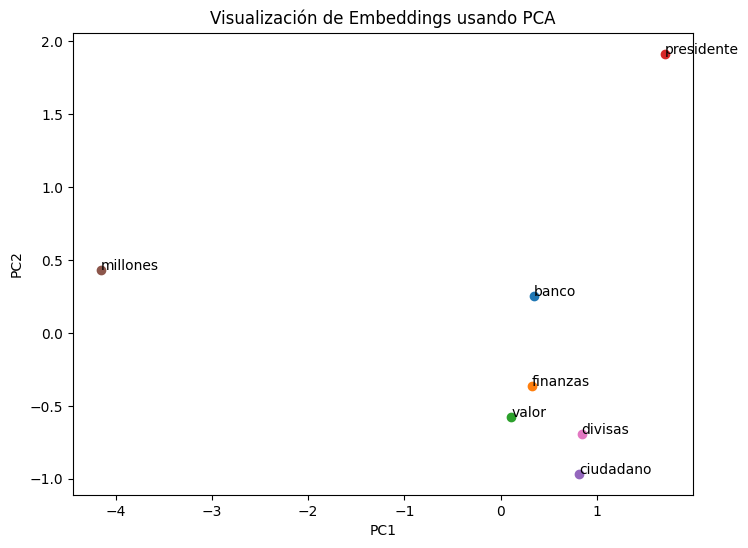

In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings(model, words):
    # Obtener los embeddings de las palabras
    embeddings = np.array([model.W1[model.word_to_index(word)] for word in words if word in model.vocab_freq])
    words = [word for word in words if word in model.vocab_freq]

    # Reducir a 2 dimensiones con PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Graficar
    plt.figure(figsize=(8, 6))
    for i, word in enumerate(words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Visualización de Embeddings usando PCA")
    plt.show()

# Palabras para visualizar
words_to_plot = ['banco', 'finanzas', 'valor', 'presidente', 'ciudadano','millones','divisas']
plot_embeddings(model, words_to_plot)


### Skip Gram

## Implementación del Algoritmo Skip-gram con Muestreo Negativo

El modelo **Skip-gram** es un tipo de modelo de lenguaje utilizado para representar palabras en un espacio de embeddings. En lugar de predecir la palabra objetivo a partir de su contexto (como en CBOW), Skip-gram toma una palabra central y trata de predecir sus palabras de contexto. Esta técnica es útil para capturar relaciones semánticas entre palabras, y es una de las arquitecturas de **Word2Vec**.

En este notebook, implementaremos el modelo Skip-gram con muestreo negativo para reducir el costo computacional, probaremos el entrenamiento en varios lotes y visualizaremos los resultados para analizar la calidad de los embeddings.


### Diferencias entre Skip-gram y CBOW

1. **Objetivo de Predicción**:
   - **CBOW**: Dado un conjunto de palabras de contexto, predice la palabra objetivo (central).
   - **Skip-gram**: Dada la palabra objetivo, predice cada palabra en su contexto.
  
2. **Uso de Muestreo Negativo**:
   - En Skip-gram, el muestreo negativo se utiliza para reducir el costo de cálculo en la predicción de múltiples palabras de contexto. Este método crea ejemplos negativos (palabras que no deberían estar en el contexto) para reducir la probabilidad de ruido en el aprendizaje.
  
3. **Arquitectura del Modelo**:
   - Ambos modelos utilizan dos matrices de embeddings (entrada y salida), pero en Skip-gram, el modelo trata de aprender una representación para predecir palabras de contexto a partir de una palabra central, lo cual ayuda a capturar relaciones entre palabras.


## Paso 1: Inicialización del Vocabulario y los Pesos

Comenzamos creando una función para inicializar el vocabulario y definir las matrices de peso (`W1` y `W2`). `W1` contendrá los embeddings de entrada, mientras que `W2` contendrá los embeddings de salida. Ambos se inicializan de manera aleatoria.


In [78]:
import numpy as np

class SkipGram:
    def __init__(self, vocab_size, embedding_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.W1 = np.random.rand(vocab_size, embedding_dim) - 0.5  # Embeddings de entrada
        self.W2 = np.random.rand(embedding_dim, vocab_size) - 0.5  # Embeddings de salida


## Paso 2: Implementación de la Función Softmax

La función `softmax` convierte los valores de salida en probabilidades, que utilizaremos para hacer predicciones sobre las palabras de contexto en Skip-gram.


In [79]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Para estabilidad numérica
    return exp_x / np.sum(exp_x)


## Paso 3: Cálculo del Error

En este paso, implementamos el cálculo del error. Usaremos la entropía cruzada para medir la diferencia entre las probabilidades predichas y las verdaderas. 
En lugar de calcular el error sobre todas las palabras, usamos **muestreo negativo**, que consiste en elegir algunas palabras aleatorias como "negativas" que no deberían aparecer en el contexto de la palabra central.


In [80]:
def negative_sampling(vocab_size, positive_indices, num_neg_samples):
    """Genera índices de palabras de muestreo negativo que no están en el contexto."""
    negatives = []
    while len(negatives) < num_neg_samples:
        neg = np.random.randint(0, vocab_size)
        if neg not in positive_indices:
            negatives.append(neg)
    return negatives


## Implementación Completa del Modelo Skip-gram con Muestreo Negativo

La implementación de `train` incluye la actualización de los embeddings para la palabra objetivo y sus palabras de contexto, así como el muestreo negativo. Cada contexto verdadero incrementa la probabilidad de las palabras reales, mientras que el muestreo negativo reduce la probabilidad de palabras que no están en el contexto, optimizando así el cálculo de probabilidades y mejorando la eficiencia del entrenamiento.


In [83]:
import re
import numpy as np

class SkipGram:
    def __init__(self, path_corpus: str, embedding_dim=10, learning_rate=0.01, window_size=2):
        # Configuración del modelo
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.window_size = window_size

        # Cargar y tokenizar el corpus
        self.path_corpus = path_corpus
        self.corpus = self.lectura_corpus(self.path_corpus)
        self.corpus_tokenized = self.tokenizer(self.corpus)

        # Construcción del vocabulario y frecuencias de unigramas
        self.vocab_freq = self.get_unigrams(self.corpus_tokenized)
        self.vocab_size = len(self.vocab_freq)
        
        # Inicialización de matrices de pesos
        self.W1 = np.random.rand(self.vocab_size, self.embedding_dim) - 0.5  # Embeddings de entrada
        self.W2 = np.random.rand(self.embedding_dim, self.vocab_size) - 0.5  # Embeddings de salida

    def lectura_corpus(self, path):
        # Leer el archivo de texto
        with open(path, mode='r', encoding='utf-8') as f:
            text = f.read().lower()
        return text

    def tokenizer(self, corpus: str) -> list:
        # Tokenización manual por palabras, eliminando puntuación
        pattern = re.compile(r'\b[a-zA-Z]+\b')
        return pattern.findall(corpus)

    def get_unigrams(self, corpus: list):
        # Crear el vocabulario y calcular frecuencia de unigramas
        unigrams = {}
        for word in corpus:
            if word not in unigrams:
                unigrams[word] = len(unigrams)  # Asignar un índice único a cada palabra
        return unigrams

    def generate_training_data(self):
        # Generar pares (objetivo, contexto) para entrenamiento de Skip-gram
        data = []
        for i in range(self.window_size, len(self.corpus_tokenized) - self.window_size):
            target_word = self.corpus_tokenized[i]
            target_idx = self.word_to_index(target_word)
            context_indices = [
                self.word_to_index(self.corpus_tokenized[j])
                for j in range(i - self.window_size, i + self.window_size + 1)
                if j != i and j >= 0 and j < len(self.corpus_tokenized)
            ]
            data.append((target_idx, context_indices))
        return data

    def word_to_index(self, word):
        # Obtener el índice de una palabra en el vocabulario
        return self.vocab_freq.get(word, -1)

    def negative_sampling(self, positive_indices, num_neg_samples):
        """Genera índices de palabras de muestreo negativo que no están en el contexto."""
        negatives = []
        while len(negatives) < num_neg_samples:
            neg = np.random.randint(0, self.vocab_size)
            if neg not in positive_indices:
                negatives.append(neg)
        return negatives

    def train(self, epochs=10, num_neg_samples=5):
        # Generar datos de entrenamiento
        training_data = self.generate_training_data()

        # Entrenamiento del modelo
        for epoch in range(epochs):
            total_loss = 0
            for target_idx, context_indices in training_data:
                # Forward pass
                h = self.W1[target_idx]
                u = np.dot(h, self.W2)
                y_pred = self.softmax(u)

                # Muestreo negativo
                neg_samples = self.negative_sampling(context_indices, num_neg_samples)

                # Ajuste para palabras de contexto reales
                EI = np.array(y_pred)
                EI[context_indices] -= 1 / len(context_indices)

                # Ajuste para muestras negativas
                EI[neg_samples] += 1 / len(neg_samples)

                # Calcular gradientes
                dW2 = np.outer(h, EI)
                dW1 = np.dot(self.W2, EI).reshape(self.W1[target_idx].shape)

                # Actualización de pesos
                self.W1[target_idx] -= self.learning_rate * dW1
                self.W2 -= self.learning_rate * dW2

                # Calcular pérdida para contexto y muestras negativas
                true_loss = -np.sum(np.log(y_pred[context_indices]))
                neg_loss = -np.sum(np.log(1 - y_pred[neg_samples]))
                total_loss += true_loss + neg_loss

            print(f"Epoch {epoch+1}, Pérdida total: {total_loss}")

    def softmax(self, x):
        # Función softmax para convertir en probabilidades
        exp_x = np.exp(x - np.max(x))  # Estabilidad numérica
        return exp_x / exp_x.sum()

    def word_vector(self, word):
        # Obtener el embedding de una palabra
        word_idx = self.word_to_index(word)
        if word_idx != -1:
            return self.W1[word_idx]
        else:
            print(f"La palabra '{word}' no está en el vocabulario.")
            return None


## Prueba de Entrenamiento en Lotes

Entrenamos el modelo con varias palabras objetivo y contextos para probar el modelo Skip-gram y observar la convergencia. El modelo ajustará los embeddings de palabras de manera que las palabras semánticamente relacionadas estén más cercanas en el espacio de embeddings.


In [84]:
# Crear una instancia del modelo SkipGram
skipgram_model = SkipGram(path_corpus='./corpus_preprocesado.txt', embedding_dim=10, learning_rate=0.01, window_size=2)

# Entrenar el modelo con 10 épocas
skipgram_model.train(epochs=10, num_neg_samples=5)

Epoch 1, Pérdida total: 4928807.538822726
Epoch 2, Pérdida total: 4920008.250712222
Epoch 3, Pérdida total: 4896185.552821751
Epoch 4, Pérdida total: 4817943.536538239
Epoch 5, Pérdida total: 4723116.283773021
Epoch 6, Pérdida total: 4664800.990538778
Epoch 7, Pérdida total: 4653753.013754979
Epoch 8, Pérdida total: 4663131.544858498
Epoch 9, Pérdida total: 4656000.004620834
Epoch 10, Pérdida total: 4735756.445940593


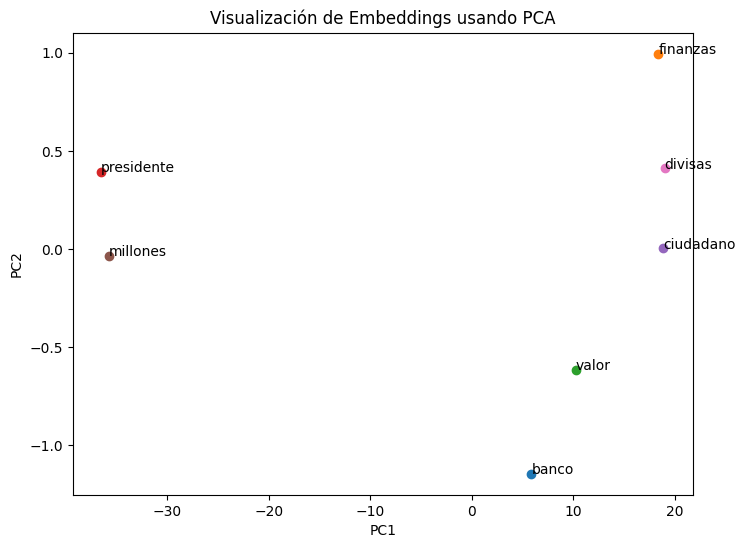

In [85]:
# Ploteamos con la funcion anterior los embedings reduciendolos su dimensionalidad
# Palabras para visualizar
words_to_plot = ['banco', 'finanzas', 'valor', 'presidente', 'ciudadano', 'millones', 'divisas']
plot_embeddings(skipgram_model, words_to_plot)

# Implementación del Algoritmo GloVe (Global Vectors for Word Representation)

GloVe es un modelo de lenguaje que utiliza estadísticas globales de co-ocurrencia para aprender representaciones vectoriales de palabras (embeddings). A diferencia de modelos basados en contexto local como Skip-gram o CBOW, GloVe se basa en la **matriz de co-ocurrencia global** para capturar relaciones semánticas en el vocabulario.

### Objetivos de GloVe
El objetivo de GloVe es encontrar vectores de palabras `wi` y `wj` tales que el producto punto de sus embeddings (junto con términos de sesgo) represente el logaritmo de la frecuencia de co-ocurrencia de esas palabras.

En este notebook, implementaremos el modelo GloVe paso a paso:
1. Construcción de la matriz de co-ocurrencia.
2. Inicialización de los vectores de palabras y términos de sesgo.
3. Definición de la función de costo y cálculo de gradientes.
4. Optimización mediante gradiente descendente.


## Paso 1: Construcción de la Matriz de Co-ocurrencia

La matriz de co-ocurrencia `X` es una matriz `V x V` (donde `V` es el tamaño del vocabulario), en la que cada entrada `X[i, j]` representa la frecuencia de co-ocurrencia entre las palabras `i` y `j` en una ventana de contexto determinada.

Para construir esta matriz, recorreremos el corpus, y para cada palabra, contaremos las palabras que aparecen en su ventana de contexto.

**Nota**: `window_size` define la cantidad de palabras alrededor de la palabra central que se considerarán en el contexto.


In [86]:
import numpy as np
from collections import defaultdict

def build_cooccurrence_matrix(corpus, vocab, window_size=2):
    """Construye la matriz de co-ocurrencia a partir del corpus y el vocabulario."""
    vocab_size = len(vocab)
    cooccurrence_matrix = np.zeros((vocab_size, vocab_size))

    # Recorre cada palabra en el corpus y cuenta co-ocurrencias en su ventana de contexto
    for i, word in enumerate(corpus):
        word_idx = vocab[word]
        start = max(0, i - window_size)
        end = min(len(corpus), i + window_size + 1)
        for j in range(start, end):
            if i != j:  # Ignorar la palabra central
                context_word = corpus[j]
                context_idx = vocab[context_word]
                cooccurrence_matrix[word_idx, context_idx] += 1

    return cooccurrence_matrix


In [87]:
# Ejemplo de corpus y vocabulario
corpus = ["el", "gato", "come", "pescado", "y", "el", "ratón", "come", "queso"]
vocab = {word: i for i, word in enumerate(set(corpus))}

# Construir la matriz de co-ocurrencia
cooccurrence_matrix = build_cooccurrence_matrix(corpus, vocab, window_size=2)
print("Matriz de co-ocurrencia:")
print(cooccurrence_matrix)


Matriz de co-ocurrencia:
[[0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 0. 0. 2.]
 [0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 2. 1. 0.]]


## Paso 2: Inicialización de Vectores y Sesgos

Para cada palabra en el vocabulario, inicializamos un vector de embedding `wi` y un término de sesgo `bi`. De manera similar, cada palabra en el contexto tendrá su propio vector `wj` y sesgo `bj`.

Los embeddings y sesgos se inicializan aleatoriamente.


In [88]:
def initialize_parameters(vocab_size, embedding_dim):
    """Inicializa los embeddings y sesgos para cada palabra en el vocabulario."""
    W = np.random.rand(vocab_size, embedding_dim) - 0.5
    W_tilde = np.random.rand(vocab_size, embedding_dim) - 0.5
    b = np.random.rand(vocab_size) - 0.5
    b_tilde = np.random.rand(vocab_size) - 0.5
    return W, W_tilde, b, b_tilde


## Paso 3: Definición de la Función de Costo

La función de costo de GloVe minimiza el error cuadrático entre el producto de los embeddings y el logaritmo de la co-ocurrencia:

\[
$J = \sum_{i,j=1}^V f(X_{ij}) \left( w_i^T \tilde{w_j} + b_i + \tilde{b_j} - \log(X_{ij}) \right)^2$
\]

Donde `f(X_ij)` es una función de ponderación que ajusta el peso de cada par `(i, j)` basado en la frecuencia `X_ij`.

Implementaremos también el cálculo de gradientes para actualizar los embeddings `W`, `W_tilde` y los sesgos `b`, `b_tilde`.


In [89]:
def weighting_function(x, xmax=100, alpha=0.75):
    """Función de ponderación f(X_ij)."""
    return (x / xmax) ** alpha if x < xmax else 1

def compute_cost_and_gradients(W, W_tilde, b, b_tilde, X, vocab_size, embedding_dim):
    """Calcula el costo y los gradientes para actualizar los parámetros."""
    cost = 0
    dW = np.zeros_like(W)
    dW_tilde = np.zeros_like(W_tilde)
    db = np.zeros(vocab_size)
    db_tilde = np.zeros(vocab_size)

    for i in range(vocab_size):
        for j in range(vocab_size):
            if X[i, j] > 0:
                # Cálculo del error
                log_Xij = np.log(X[i, j])
                weight = weighting_function(X[i, j])
                diff = np.dot(W[i], W_tilde[j]) + b[i] + b_tilde[j] - log_Xij
                cost += weight * (diff ** 2)

                # Gradientes
                grad = 2 * weight * diff
                dW[i] += grad * W_tilde[j]
                dW_tilde[j] += grad * W[i]
                db[i] += grad
                db_tilde[j] += grad

    return cost, dW, dW_tilde, db, db_tilde


## Paso 4: Optimización mediante Gradiente Descendente

Usamos los gradientes calculados para actualizar los parámetros `W`, `W_tilde`, `b` y `b_tilde`. Realizaremos iteraciones sobre los datos hasta que la función de costo converja o se alcance un número máximo de épocas.


In [91]:
def train_glove(X, vocab_size, embedding_dim, epochs=100, learning_rate=0.01):
    """Entrena el modelo GloVe mediante gradiente descendente."""
    W, W_tilde, b, b_tilde = initialize_parameters(vocab_size, embedding_dim)

    for epoch in range(epochs):
        cost, dW, dW_tilde, db, db_tilde = compute_cost_and_gradients(W, W_tilde, b, b_tilde, X, vocab_size, embedding_dim)

        # Actualizar parámetros
        W -= learning_rate * dW
        W_tilde -= learning_rate * dW_tilde
        b -= learning_rate * db
        b_tilde -= learning_rate * db_tilde

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, Costo: {cost:.4f}")

    return W, W_tilde, b, b_tilde


In [2]:
import numpy as np
import re

class GloVe:
    def __init__(self, path_corpus, embedding_dim=10, window_size=2, xmax=100, alpha=0.75):
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.xmax = xmax
        self.alpha = alpha

        # Cargar y tokenizar el corpus
        self.path_corpus = path_corpus
        self.corpus = self.lectura_corpus(self.path_corpus)
        self.corpus_tokenized = self.tokenizer(self.corpus)

        # Construir vocabulario y matriz de co-ocurrencia
        self.vocab = {word: i for i, word in enumerate(set(self.corpus_tokenized))}
        self.vocab_size = len(self.vocab)
        self.X = self.build_cooccurrence_matrix(self.corpus_tokenized, self.vocab, window_size)

        # Inicializar vectores de palabras y términos de sesgo
        self.W, self.W_tilde, self.b, self.b_tilde = self.initialize_parameters(self.vocab_size, embedding_dim)

    def lectura_corpus(self, path):
        # Leer el archivo de texto
        with open(path, mode='r', encoding='utf-8') as f:
            text = f.read().lower()
        return text

    def tokenizer(self, corpus):
        # Tokenización manual por palabras, eliminando puntuación
        pattern = re.compile(r'\b[a-zA-Z]+\b')
        return pattern.findall(corpus)

    def build_cooccurrence_matrix(self, corpus, vocab, window_size):
        """Construye la matriz de co-ocurrencia a partir del corpus y el vocabulario."""
        vocab_size = len(vocab)
        cooccurrence_matrix = np.zeros((vocab_size, vocab_size))

        # Recorre cada palabra en el corpus y cuenta co-ocurrencias en su ventana de contexto
        for i, word in enumerate(corpus):
            word_idx = vocab[word]
            start = max(0, i - window_size)
            end = min(len(corpus), i + window_size + 1)
            for j in range(start, end):
                if i != j:  # Ignorar la palabra central
                    context_word = corpus[j]
                    context_idx = vocab[context_word]
                    cooccurrence_matrix[word_idx, context_idx] += 1

        return cooccurrence_matrix

    def initialize_parameters(self, vocab_size, embedding_dim):
        """Inicializa los embeddings y sesgos para cada palabra en el vocabulario."""
        W = np.random.rand(vocab_size, embedding_dim) - 0.5
        W_tilde = np.random.rand(vocab_size, embedding_dim) - 0.5
        b = np.random.rand(vocab_size) - 0.5
        b_tilde = np.random.rand(vocab_size) - 0.5
        return W, W_tilde, b, b_tilde

    def weighting_function(self, x):
        """Función de ponderación f(X_ij)."""
        return (x / self.xmax) ** self.alpha if x < self.xmax else 1

    def compute_cost_and_gradients(self):
        """Calcula el costo y los gradientes para actualizar los parámetros."""
        cost = 0
        dW = np.zeros_like(self.W)
        dW_tilde = np.zeros_like(self.W_tilde)
        db = np.zeros(self.vocab_size)
        db_tilde = np.zeros(self.vocab_size)

        for i in range(self.vocab_size):
            for j in range(self.vocab_size):
                if self.X[i, j] > 0:
                    log_Xij = np.log(self.X[i, j])
                    weight = self.weighting_function(self.X[i, j])
                    diff = np.dot(self.W[i], self.W_tilde[j]) + self.b[i] + self.b_tilde[j] - log_Xij
                    cost += weight * (diff ** 2)

                    # Gradientes
                    grad = 2 * weight * diff
                    dW[i] += grad * self.W_tilde[j]
                    dW_tilde[j] += grad * self.W[i]
                    db[i] += grad
                    db_tilde[j] += grad

        return cost, dW, dW_tilde, db, db_tilde

    def train(self, epochs=100, learning_rate=0.01):
        """Entrena el modelo GloVe mediante gradiente descendente."""
        for epoch in range(epochs):
            cost, dW, dW_tilde, db, db_tilde = self.compute_cost_and_gradients()

            # Actualización de parámetros
            self.W -= learning_rate * dW
            self.W_tilde -= learning_rate * dW_tilde
            self.b -= learning_rate * db
            self.b_tilde -= learning_rate * db_tilde

            
            print(f"Epoch {epoch+1}, Costo: {cost:.4f}")

    def get_embedding(self, word):
        """Obtiene el embedding de una palabra."""
        idx = self.vocab.get(word)
        if idx is not None:
            return self.W[idx]
        else:
            print(f"La palabra '{word}' no está en el vocabulario.")
            return None


In [3]:
# Crear una instancia y entrenar el modelo GloVe
glove_model = GloVe(path_corpus='./corpus_preprocesado.txt', embedding_dim=10, window_size=2)
glove_model.train(epochs=25, learning_rate=0.01)

Epoch 1, Costo: 10327.7925
Epoch 2, Costo: 7229.6658
Epoch 3, Costo: 6498.9640
Epoch 4, Costo: 6083.5970
Epoch 5, Costo: 5792.4456
Epoch 6, Costo: 5568.6863
Epoch 7, Costo: 5387.4132
Epoch 8, Costo: 5235.4551
Epoch 9, Costo: 5104.9713
Epoch 10, Costo: 4990.8930
Epoch 11, Costo: 4889.7431
Epoch 12, Costo: 4799.0295
Epoch 13, Costo: 4716.9041
Epoch 14, Costo: 4641.9573
Epoch 15, Costo: 4573.0869
Epoch 16, Costo: 4509.4116
Epoch 17, Costo: 4450.2127
Epoch 18, Costo: 4394.8937
Epoch 19, Costo: 4342.9528
Epoch 20, Costo: 4293.9635
Epoch 21, Costo: 4247.5606
Epoch 22, Costo: 4203.4303
Epoch 23, Costo: 4161.3021
Epoch 24, Costo: 4120.9428
Epoch 25, Costo: 4082.1514


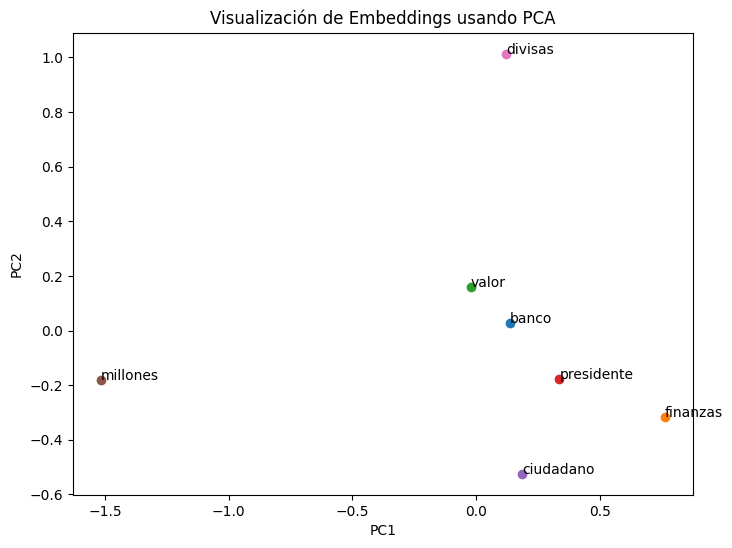

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_embeddings(model, words):
    # Obtener los embeddings de las palabras
    embeddings = []
    valid_words = []
    for word in words:
        embedding = model.get_embedding(word)
        if embedding is not None:
            embeddings.append(embedding)
            valid_words.append(word)
    
    # Convertir a un array de numpy
    embeddings = np.array(embeddings)
    
    # Reducir a 2 dimensiones con PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Graficar
    plt.figure(figsize=(8, 6))
    for i, word in enumerate(valid_words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Visualización de Embeddings usando PCA")
    plt.show()

# Palabras para visualizar
words_to_plot = ['banco', 'finanzas', 'valor', 'presidente', 'ciudadano', 'millones', 'divisas']
plot_embeddings(glove_model, words_to_plot)
